In [1]:
import torch, cupy as cp

print("PyTorch CUDA available? ", torch.cuda.is_available())           # True 여야 함
print("Number of GPUs (CuPy)  : ", cp.cuda.runtime.getDeviceCount())   # 1 이상이어야 함


PyTorch CUDA available?  True
Number of GPUs (CuPy)  :  1


In [2]:
import scanpy as sc
import scvi

# 1) 데이터 로딩
adata = sc.datasets.pbmc3k()
adata.var_names_make_unique()

# 2) scVI 설정
scvi.model.SCVI.setup_anndata(adata)

# 3) 모델 학습
model = scvi.model.SCVI(adata, n_latent=10, gene_likelihood="nb")
model.train(max_epochs=400, accelerator="auto")



/root/miniconda3/envs/scvi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/miniconda3/envs/scvi_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasin

Epoch 400/400: 100%|██████████| 400/400 [02:27<00:00,  2.72it/s, v_num=1, train_loss_step=2.57e+3, train_loss_epoch=2.59e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:27<00:00,  2.71it/s, v_num=1, train_loss_step=2.57e+3, train_loss_epoch=2.59e+3]


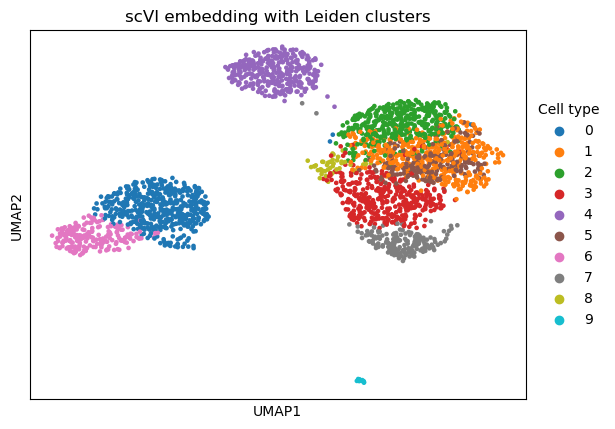

In [10]:
# 4) 잠재 임베딩 추출
adata.obsm["X_scvi"] = model.get_latent_representation()

# (5) UMAP 계산
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)

# key_added를 'leiden_scvi'로 간단히 지정
sc.tl.leiden(adata, key_added="leiden_scvi")

# (6) 시각화
import matplotlib.pyplot as plt

ax = sc.pl.umap(
    adata,
    color="scVI embedding with Leiden clusters",        # 이제 컬럼명이 맞습니다
    legend_loc="right margin",
    show=False,
)
ax.legend_.set_title("Cell type")
plt.show()


In [10]:
import numpy as np
import cupy as cp
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

def evaluate_embedding_gpu(
    X_hi_cp, Z_low_cp,
    k=30,
    n_pairs=20_000,
    random_state=0
):
    N = X_hi_cp.shape[0]
    rs = cp.random.RandomState(random_state)
    idx = rs.randint(0, N, size=(n_pairs, 2))

    # 1) 거리 계산
    Dx = cp.linalg.norm(
        X_hi_cp[idx[:, 0]] - X_hi_cp[idx[:, 1]], axis=1
    ).astype(cp.float32)
    Dz = cp.linalg.norm(
        Z_low_cp[idx[:, 0]] - Z_low_cp[idx[:, 1]], axis=1
    ).astype(cp.float32)

    # 2) Pearson correlation (GPU)
    x_mean = Dx.mean()
    z_mean = Dz.mean()
    cov    = ((Dx - x_mean) * (Dz - z_mean)).mean()
    std_x  = (Dx - x_mean).std()
    std_z  = (Dz - z_mean).std()
    corr   = cov / (std_x * std_z + 1e-8)

    # 3) 1D EMD
    Dx_s = cp.sort(Dx)
    Dz_s = cp.sort(Dz)
    emd   = cp.mean(cp.abs(Dx_s - Dz_s))

    # 4) KNN-overlap (CPU)
    X_np = cp.asnumpy(X_hi_cp)
    Z_np = cp.asnumpy(Z_low_cp)
    nn_hi = NearestNeighbors(n_neighbors=k+1).fit(X_np)
    nn_lo = NearestNeighbors(n_neighbors=k+1).fit(Z_np)
    knn_hi = nn_hi.kneighbors(X_np, return_distance=False)[:, 1:]
    knn_lo = nn_lo.kneighbors(Z_np, return_distance=False)[:, 1:]
    overlap = (knn_hi[:, :, None] == knn_lo[:, None, :]).any(-1).mean()

    return {
        'corr':     float(corr),
        'emd':      float(emd),
        'knn_pres': float(overlap)
    }


In [ ]:
# --- (3) 원본 고차원과 잠재임베딩 준비 ---
# adata.X 가 sparse matrix 일 경우 .A로 밀집 배열 변환
X_hi = adata.X.A if hasattr(adata.X, "A") else adata.X
Z_low = adata.obsm["X_scvi"]

# Cupy array 로 변환
X_hi_cp = cp.array(X_hi, dtype=cp.float32)
Z_low_cp = cp.array(Z_low, dtype=cp.float32)

# --- (4) GPU 평가 및 실루엣 스코어 계산 ---
metrics = evaluate_embedding_gpu(X_hi_cp, Z_low_cp)
sil_score = silhouette_score(Z_low, adata.obs["leiden_scvi"].astype(int))

print("=== GPU 기반 임베딩 평가 결과 ===")
print(f"Pearson Corr: {metrics['corr']:.4f}")
print(f"1D EMD       : {metrics['emd']:.4f}")
print(f"KNN Pres.    : {metrics['knn_pres']:.4f}")
print("\n실루엣 스코어:", f"{sil_score:.4f}")


In [ ]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph, csr_matrix
from scipy.sparse.linalg import eigsh
import scanpy as sc

def compute_spectrum(coords, k=15, r=20):
    """
    Compute the first r+1 eigenvalues of the normalized Laplacian
    from a Gaussian-weighted, symmetric k-NN graph on coords (n×d).
    """
    # 1) distance-based k-NN graph
    D = kneighbors_graph(coords, n_neighbors=k, mode='distance', include_self=False)
    D = 0.5 * (D + D.T)

    # 2) Gaussian kernel weights
    sigma = np.median(D.data)
    W_data = np.exp(- (D.data**2) / (2 * sigma**2 + 1e-16))
    W = csr_matrix((W_data, D.indices, D.indptr), shape=D.shape)
    W = 0.5 * (W + W.T)

    # 3) normalized Laplacian
    L = csgraph.laplacian(W, normed=True)

    # 4) compute smallest r+1 eigenvalues
    m = min(r+1, L.shape[0]-2)
    vals, _ = eigsh(L, k=m, which='SM', tol=1e-3)
    vals = np.sort(vals)
    if vals.shape[0] < r+1:
        vals = np.pad(vals, (0, r+1-vals.shape[0]), 'constant')
    return vals

def spectral_graph_concordance(vals_nat, vals_lat, r=20):
    """
    Compute SGC(r) = 1 – sum_i|λ_nat_i – λ_lat_i| / sum_i λ_nat_i, clipped to [0,1].
    """
    diff = np.abs(vals_nat[1:r+1] - vals_lat[1:r+1]).sum()
    denom = vals_nat[1:r+1].sum()
    if denom <= 0:
        return 0.0
    return float(np.clip(1 - diff/denom, 0.0, 1.0))

# --- Ensure we have a reference native embedding (PCA) ---
if 'X_pca' not in adata.obsm:
    sc.pp.pca(adata, n_comps=50)
native_coords = adata.obsm['X_pca'][:, :50]  # use first 50 PCs for native graph

# --- Compute native spectrum once ---
k, r = 15, 20
vals_nat = compute_spectrum(native_coords, k=k, r=r)

# --- Compute latent spectrum for scVI embedding ---
latent_coords = adata.obsm['X_scvi']  # (n_cells, n_latent)
vals_lat = compute_spectrum(latent_coords, k=k, r=r)

# --- Compute and report SGC ---
sgc_scvi = spectral_graph_concordance(vals_nat, vals_lat, r=r)
print(f"SCVI embedding Spectral Graph Concordance (r={r}, k={k}): {sgc_scvi:.3f}")
